# 広告売上予測モデル（AutoML）
- **目的変数**: `revenue`
- **特徴量**: プラットフォーム別支出、曜日、月、年
- **入力**: `azure_databricks_test.ad_analytics.gold_campaign_performance`

## 0) セットアップ

In [0]:
from pyspark.sql.functions import col, sum as _sum, to_date, lower, when, lit, dayofweek, month, year
import databricks.automl as automl
import mlflow
import pandas as pd

CATALOG_NAME = "azure_databricks_test"
SCHEMA_NAME  = "ad_analytics"
TABLE_NAME   = "gold_campaign_performance"
DB_3PART     = f"{CATALOG_NAME}.{SCHEMA_NAME}.{TABLE_NAME}"

TIMEOUT_MINUTES = 5
PRIMARY_METRIC  = "rmse"

print(f"入力テーブル: {DB_3PART}")

入力テーブル: azure_databricks_test.ad_analytics.gold_campaign_performance


## 1) データ読み込み

In [0]:
df_raw = spark.table(DB_3PART).withColumn("date", to_date(col("date")))

print(f"総行数: {df_raw.count()}")
print(f"期間: {df_raw.agg({'date': 'min'}).collect()[0][0]} ～ {df_raw.agg({'date': 'max'}).collect()[0][0]}")

# データプレビュー
display(df_raw.limit(10))

総行数: 2182
期間: 2025-09-05 ～ 2025-12-04


campaign_id,campaign_name,date,year_month,day_of_week,ad_platform,target_category,impressions,clicks,ad_cost,ctr,cpc,revenue,profit,conversions,unique_customers,avg_order_value,cvr,roas,cpa,roi,calculation_timestamp
C005,シューズ_プロモ,2025-09-11,2025-09,5,facebook,シューズ,6497,178,10589.5,2.73972602739726,59.491573033707866,232201,113406,15,15,15480.066666666668,8.426966292134832,21.927475329335664,705.9666666666667,970.9287501770622,2025-12-08T07:42:08.403434Z
C005,シューズ_プロモ,2025-09-11,2025-09,5,google,シューズ,7467,168,11541.55,2.2498995580554437,68.69970238095237,232201,113406,15,15,15480.066666666668,8.928571428571429,20.118701560882204,769.4366666666666,882.5889936793585,2025-12-08T07:42:08.403434Z
C005,シューズ_プロモ,2025-09-11,2025-09,5,twitter,シューズ,10982,251,10848.87,2.2855581861227465,43.22258964143427,232201,113406,15,15,15480.066666666668,5.9760956175298805,21.40324291838689,723.258,945.3254578587448,2025-12-08T07:42:08.403434Z
C005,シューズ_プロモ,2025-09-11,2025-09,5,youtube,シューズ,6174,114,10993.7,1.84645286686103,96.43596491228071,232201,113406,15,15,15480.066666666668,13.157894736842104,21.121278550442526,732.9133333333334,931.5544357222773,2025-12-08T07:42:08.403434Z
C007,デニム_特集,2025-09-20,2025-09,7,google,ボトムス,5683,141,11185.74,2.481083934541615,79.33148936170213,247323,125998,16,16,15457.6875,11.347517730496454,22.11056219794131,699.10875,1026.416312197494,2025-12-08T07:42:08.403434Z
C007,デニム_特集,2025-09-20,2025-09,7,instagram,ボトムス,4467,142,11260.2,3.1788672487127827,79.29718309859156,247323,125998,16,16,15457.6875,11.267605633802818,21.96435232056269,703.7625,1018.9676915152484,2025-12-08T07:42:08.403434Z
C007,デニム_特集,2025-09-20,2025-09,7,twitter,ボトムス,9837,231,10817.09,2.348276913693199,46.82722943722944,247323,125998,16,16,15457.6875,6.926406926406926,22.86409746059245,676.068125,1064.8049521636597,2025-12-08T07:42:08.403434Z
C007,デニム_特集,2025-09-20,2025-09,7,youtube,ボトムス,5201,108,10720.06,2.0765237454335703,99.25981481481482,247323,125998,16,16,15457.6875,14.814814814814813,23.071046244144156,670.00375,1075.3478991722063,2025-12-08T07:42:08.403434Z
C006,アクセサリー_キャンペーン,2025-09-26,2025-09,6,facebook,アクセサリー,7603,213,14502.69,2.801525713534131,68.08774647887324,107485,56925,10,10,10748.5,4.694835680751173,7.411383681234309,1450.269,292.5133888954394,2025-12-08T07:42:08.403434Z
C006,アクセサリー_キャンペーン,2025-09-26,2025-09,6,twitter,アクセサリー,10351,227,12970.66,2.1930248285189835,57.13947136563877,107485,56925,10,10,10748.5,4.405286343612335,8.28677954707008,1297.066,338.87512277709845,2025-12-08T07:42:08.403434Z


## 2) プラットフォーム別支出の集計

In [0]:
platform_normalized = df_raw.withColumn(
    "platform_key",
    when(lower(col("ad_platform")).like("%google%"), lit("google"))
    .when(lower(col("ad_platform")).like("%facebook%"), lit("facebook"))
    .when(lower(col("ad_platform")).like("%instagram%"), lit("instagram"))
    .when(lower(col("ad_platform")).like("%meta%"), lit("facebook"))
    .when(lower(col("ad_platform")).like("%twitter%"), lit("twitter"))
    .otherwise(lit("other"))
)

spend_daily = (
    platform_normalized
    .groupBy("date")
    .pivot("platform_key", ["google","facebook","instagram","twitter"])
    .agg(_sum("ad_cost").alias("spend"))
    .fillna(0.0)
    .withColumnRenamed("google", "spend_google")
    .withColumnRenamed("facebook", "spend_facebook")
    .withColumnRenamed("instagram", "spend_instagram")
    .withColumnRenamed("twitter", "spend_twitter")
)

display(spend_daily.orderBy(col("date").desc()).limit(10))

date,spend_google,spend_facebook,spend_instagram,spend_twitter
2025-12-04,70965.38,39530.28,82167.84999999999,68150.0
2025-12-03,74797.21,101829.19,35529.97,60226.25
2025-12-02,94588.07999999999,47541.86,39808.58,127147.99999999999
2025-12-01,57669.93,33121.200000000004,90254.04999999999,88003.39
2025-11-30,41667.91,85174.93,60764.0,113395.56999999999
2025-11-29,111591.5,45283.01,117815.58,103613.45
2025-11-28,97071.28,75584.67000000001,67775.45000000001,96316.87000000001
2025-11-27,86066.70999999999,90972.03,93230.29000000001,54954.450000000004
2025-11-26,55582.909999999996,95183.15000000001,70250.54000000001,87656.12
2025-11-25,72108.52,53866.61,51801.47,107432.70999999999


## 3) 売上集計と特徴量結合

In [0]:
target_daily = df_raw.groupBy("date").agg(_sum("revenue").alias("revenue"))

base_df = (
    target_daily
    .join(spend_daily, on="date", how="left")
    .select("date", "revenue", "spend_google", "spend_facebook", "spend_instagram", "spend_twitter")
    .fillna(0.0, subset=["spend_google", "spend_facebook", "spend_instagram", "spend_twitter"])
)

print(f"結合後のデータ: {base_df.count()}行")
display(base_df.orderBy(col("date").desc()).limit(20))

結合後のデータ: 91行


date,revenue,spend_google,spend_facebook,spend_instagram,spend_twitter
2025-12-04,9171142,70965.38,39530.28,82167.84999999999,68150.0
2025-12-03,8422083,74797.21,101829.19,35529.97,60226.25
2025-12-02,7364487,94588.07999999999,47541.86,39808.58,127147.99999999999
2025-12-01,8553614,57669.93,33121.200000000004,90254.04999999999,88003.39
2025-11-30,10126959,41667.91,85174.93,60764.0,113395.56999999999
2025-11-29,10089957,111591.5,45283.01,117815.58,103613.45
2025-11-28,6266854,97071.28,75584.67000000001,67775.45000000001,96316.87000000001
2025-11-27,9328216,86066.70999999999,90972.03,93230.29000000001,54954.450000000004
2025-11-26,8392351,55582.909999999996,95183.15000000001,70250.54000000001,87656.12
2025-11-25,8312275,72108.52,53866.61,51801.47,107432.70999999999


## 4) 特徴量拡張

In [0]:
feat_df = (
    base_df
    .withColumn("dow", dayofweek(col("date")))  # 曜日 (1=日曜, 7=土曜)
    .withColumn("mon", month(col("date")))       # 月 (1-12)
    .withColumn("yr", year(col("date")))         # 年
)

print(f"特徴量準備完了: {feat_df.count()}行")
feat_df.printSchema()
display(feat_df.orderBy(col("date").desc()).limit(20))

特徴量準備完了: 91行
root
 |-- date: date (nullable = true)
 |-- revenue: long (nullable = true)
 |-- spend_google: double (nullable = false)
 |-- spend_facebook: double (nullable = false)
 |-- spend_instagram: double (nullable = false)
 |-- spend_twitter: double (nullable = false)
 |-- dow: integer (nullable = true)
 |-- mon: integer (nullable = true)
 |-- yr: integer (nullable = true)



date,revenue,spend_google,spend_facebook,spend_instagram,spend_twitter,dow,mon,yr
2025-12-04,9171142,70965.38,39530.28,82167.84999999999,68150.0,5,12,2025
2025-12-03,8422083,74797.21,101829.19,35529.97,60226.25,4,12,2025
2025-12-02,7364487,94588.07999999999,47541.86,39808.58,127147.99999999999,3,12,2025
2025-12-01,8553614,57669.93,33121.200000000004,90254.04999999999,88003.39,2,12,2025
2025-11-30,10126959,41667.91,85174.93,60764.0,113395.56999999999,1,11,2025
2025-11-29,10089957,111591.5,45283.01,117815.58,103613.45,7,11,2025
2025-11-28,6266854,97071.28,75584.67000000001,67775.45000000001,96316.87000000001,6,11,2025
2025-11-27,9328216,86066.70999999999,90972.03,93230.29000000001,54954.450000000004,5,11,2025
2025-11-26,8392351,55582.909999999996,95183.15000000001,70250.54000000001,87656.12,4,11,2025
2025-11-25,8312275,72108.52,53866.61,51801.47,107432.70999999999,3,11,2025


## 5) AutoML トレーニング

In [0]:
print("=" * 60)
print("AutoML トレーニング開始...")
print("=" * 60)

FEATURE_COLUMNS = ['spend_google', 'spend_facebook', 'spend_instagram', 
                   'spend_twitter', 'dow', 'mon', 'yr']

# date列を完全に除外
training_df = feat_df.select(['revenue'] + FEATURE_COLUMNS)

print(f"データ: {training_df.count()}行 × {len(training_df.columns)}列")
print(f"列: {training_df.columns}")

summary = automl.regress(
    dataset=training_df,
    target_col="revenue",
    primary_metric=PRIMARY_METRIC,
    timeout_minutes=TIMEOUT_MINUTES
)

print("\n" + "=" * 60)
print("AutoML 完了")
print("=" * 60)
print(f"Best Trial ID: {summary.best_trial.mlflow_run_id}")
print(f"Best Model URI: {summary.best_trial.model_path}")
print(f"Experiment ID: {summary.experiment.experiment_id}")
print("=" * 60)

AutoML トレーニング開始...
データ: 91行 × 8列
列: ['revenue', 'spend_google', 'spend_facebook', 'spend_instagram', 'spend_twitter', 'dow', 'mon', 'yr']


2025/12/11 02:16:51 INFO databricks.automl.client.manager: AutoML will optimize for root mean squared error metric, which is tracked as val_root_mean_squared_error in the MLflow experiment.
2025/12/11 02:16:52 INFO databricks.automl.client.manager: MLflow Experiment ID: 1738068970225055
2025/12/11 02:16:52 INFO databricks.automl.client.manager: MLflow Experiment: https://adb-1472737724393981.1.azuredatabricks.net/?o=1472737724393981#mlflow/experiments/1738068970225055
2025/12/11 02:18:16 INFO databricks.automl.client.manager: Data exploration notebook: https://adb-1472737724393981.1.azuredatabricks.net/?o=1472737724393981#notebook/1738068970225060
2025/12/11 02:23:15 INFO databricks.automl.client.manager: AutoML experiment completed successfully.


,Train,Validation,Test
root_mean_squared_error,1.165568e+06,1.507532e+06,1.417841e+06
score,0.472,0.046,0.013
mean_squared_error,1.358550e+12,2.272653e+12,2.010274e+12
example_count,51.000,19.000,21.000
mean_on_target,8.894654e+06,8.775136e+06,8.809808e+06
r2_score,0.472,0.046,0.013
mean_absolute_error,917130.620,1.195043e+06,1.038082e+06
mean_absolute_percentage_error,0.118,0.144,0.118
max_error,3.904691e+06,3.271509e+06,3.155748e+06
sum_on_target,4.536274e+08,1.667276e+08,1.850060e+08



AutoML 完了
Best Trial ID: 33c7cc2090b541aab4ea72b117b64965
Best Model URI: dbfs:/databricks/mlflow-tracking/1738068970225055/33c7cc2090b541aab4ea72b117b64965/artifacts/model
Experiment ID: 1738068970225055


## 6) 結果確認

AutoMLが生成したノートブックで以下を確認できます：
- モデルの詳細情報
- 特徴量重要度
- 評価指標（RMSE, R², MAEなど）
- 予測結果の可視化

In [0]:
# 実験情報の保存
experiment_id = summary.experiment.experiment_id
best_run_id = summary.best_trial.mlflow_run_id
model_uri = summary.best_trial.model_path

print("=" * 60)
print("実験情報")
print("=" * 60)
print(f"Experiment ID: {experiment_id}")
print(f"Best Run ID: {best_run_id}")
print(f"Model URI: {model_uri}")
print("=" * 60)

実験情報
Experiment ID: 1738068970225055
Best Run ID: 33c7cc2090b541aab4ea72b117b64965
Model URI: dbfs:/databricks/mlflow-tracking/1738068970225055/33c7cc2090b541aab4ea72b117b64965/artifacts/model


## 8) バックワードテスト（最後の10日間で検証）

バックワードテスト：最後の10日間で予測精度を検証

Test Period: 2025-11-25 - 2025-12-04
Test Days: 10 days

Prediction Results:
      Date   Actual    Predicted         Error  Error_Pct
2025-11-25  8312275 8.717654e+06 -4.053792e+05      -4.88
2025-11-26  8392351 8.660860e+06 -2.685086e+05      -3.20
2025-11-27  9328216 8.660860e+06  6.673564e+05       7.15
2025-11-28  6266854 6.954608e+06 -6.877542e+05     -10.97
2025-11-29 10089957 8.717654e+06  1.372303e+06      13.60
2025-11-30 10126959 9.109593e+06  1.017366e+06      10.05
2025-12-01  8553614 9.109593e+06 -5.559786e+05      -6.50
2025-12-02  7364487 8.717654e+06 -1.353167e+06     -18.37
2025-12-03  8422083 8.183908e+06  2.381750e+05       2.83
2025-12-04  9171142 8.717654e+06  4.534878e+05       4.94

Evaluation Metrics (Last 10 Days)
RMSE: JPY 804,711
MAE:  JPY 701,948
MAPE: 8.25%
R2:   0.4835

Avg Actual:    JPY 8,602,794
Avg Predicted: JPY 8,555,004
Avg Error:     JPY 47,790


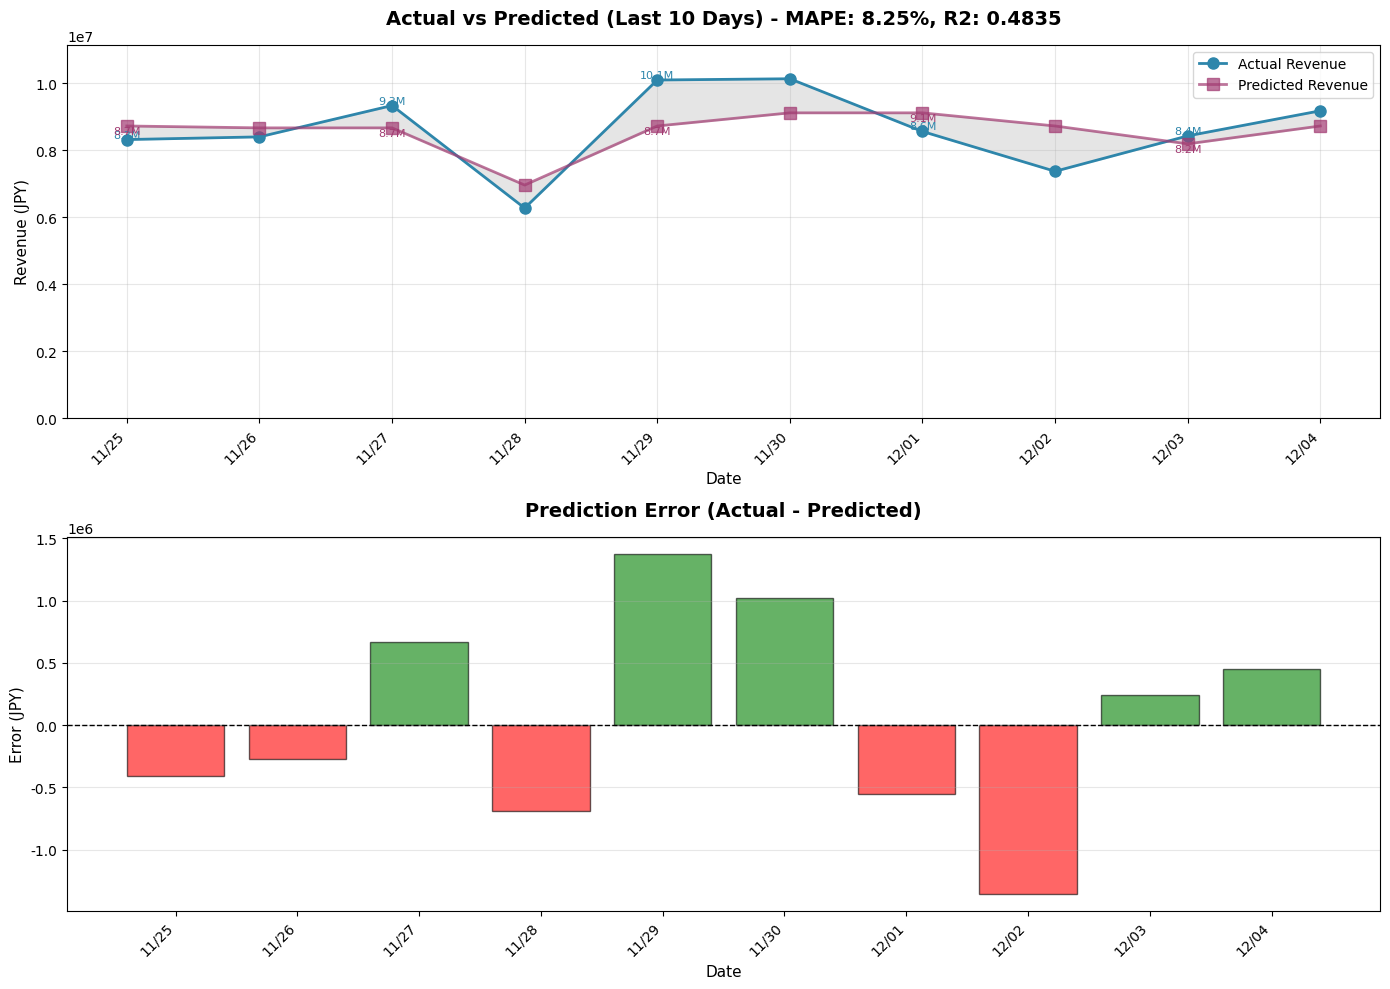


[OK] Graph displayed


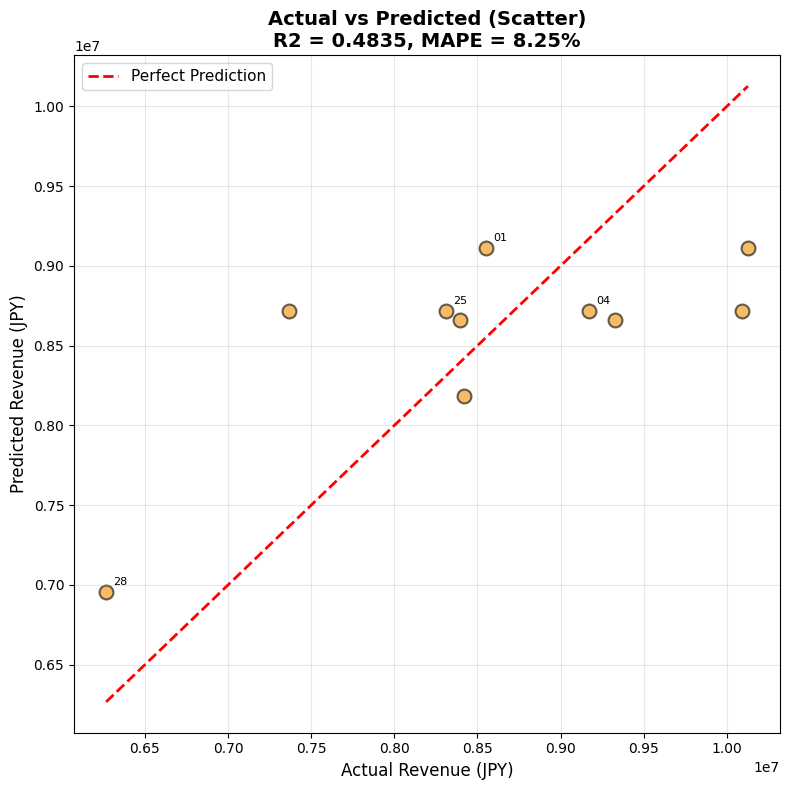

Daily Performance Details
      Date   Actual    Predicted         Error  Error_Pct    Abs_Error  Accuracy
2025-11-25  8312275 8.717654e+06 -4.053792e+05      -4.88 4.053792e+05     95.12
2025-11-26  8392351 8.660860e+06 -2.685086e+05      -3.20 2.685086e+05     96.80
2025-11-27  9328216 8.660860e+06  6.673564e+05       7.15 6.673564e+05     92.85
2025-11-28  6266854 6.954608e+06 -6.877542e+05     -10.97 6.877542e+05     89.03
2025-11-29 10089957 8.717654e+06  1.372303e+06      13.60 1.372303e+06     86.40
2025-11-30 10126959 9.109593e+06  1.017366e+06      10.05 1.017366e+06     89.95
2025-12-01  8553614 9.109593e+06 -5.559786e+05      -6.50 5.559786e+05     93.50
2025-12-02  7364487 8.717654e+06 -1.353167e+06     -18.37 1.353167e+06     81.63
2025-12-03  8422083 8.183908e+06  2.381750e+05       2.83 2.381750e+05     97.17
2025-12-04  9171142 8.717654e+06  4.534878e+05       4.94 4.534878e+05     95.06

[BEST] Top 3 Most Accurate Days
      Date  Actual    Predicted  Error_Pct
2025-12

In [0]:
# 日本語フォント設定
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams

# フォント設定（Databricksで利用可能なフォント）
rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'sans-serif']
rcParams['axes.unicode_minus'] = False

print("=" * 60)
print("バックワードテスト：最後の10日間で予測精度を検証")
print("=" * 60)

# 元のデータ（date列を含む）を取得
test_data_with_date = feat_df.orderBy(col("date").desc()).limit(10).toPandas()
test_data_with_date = test_data_with_date.sort_values('date').reset_index(drop=True)

# 特徴量のみを抽出
test_features = test_data_with_date[FEATURE_COLUMNS]
actual_revenue = test_data_with_date['revenue']
test_dates = pd.to_datetime(test_data_with_date['date'])

print(f"\nTest Period: {test_dates.min().strftime('%Y-%m-%d')} - {test_dates.max().strftime('%Y-%m-%d')}")
print(f"Test Days: {len(test_data_with_date)} days\n")

# 予測実行
predicted_revenue = loaded_model.predict(test_features)

# 結果をDataFrameにまとめる
result_df = pd.DataFrame({
    'Date': test_dates.dt.strftime('%Y-%m-%d'),
    'Actual': actual_revenue.values,
    'Predicted': predicted_revenue,
    'Error': actual_revenue.values - predicted_revenue,
    'Error_Pct': ((actual_revenue.values - predicted_revenue) / actual_revenue.values * 100).round(2)
})

print("Prediction Results:")
print(result_df.to_string(index=False))
print("\n" + "=" * 60)

# %% [markdown]
# ### 評価指標の計算

# %%
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 評価指標を計算
rmse = np.sqrt(mean_squared_error(actual_revenue, predicted_revenue))
mae = mean_absolute_error(actual_revenue, predicted_revenue)
r2 = r2_score(actual_revenue, predicted_revenue)
mape = np.mean(np.abs((actual_revenue - predicted_revenue) / actual_revenue)) * 100

print("=" * 60)
print("Evaluation Metrics (Last 10 Days)")
print("=" * 60)
print(f"RMSE: JPY {rmse:,.0f}")
print(f"MAE:  JPY {mae:,.0f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2:   {r2:.4f}")
print("\n" + "=" * 60)
print(f"Avg Actual:    JPY {actual_revenue.mean():,.0f}")
print(f"Avg Predicted: JPY {predicted_revenue.mean():,.0f}")
print(f"Avg Error:     JPY {(actual_revenue - predicted_revenue).mean():,.0f}")
print("=" * 60)

# %% [markdown]
# ### 可視化：実績 vs 予測

# %%
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Time Series Plot
axes[0].plot(test_dates, actual_revenue, marker='o', linewidth=2, 
             markersize=8, label='Actual Revenue', color='#2E86AB')
axes[0].plot(test_dates, predicted_revenue, marker='s', linewidth=2, 
             markersize=8, label='Predicted Revenue', color='#A23B72', alpha=0.7)
axes[0].fill_between(test_dates, actual_revenue, predicted_revenue, 
                      alpha=0.2, color='gray')
axes[0].set_title(f'Actual vs Predicted (Last 10 Days) - MAPE: {mape:.2f}%, R2: {r2:.4f}', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Revenue (JPY)', fontsize=11)
axes[0].set_ylim(bottom=0)
# Y軸の範囲を0から最大値の1.1倍に設定
max_revenue = max(actual_revenue.max(), predicted_revenue.max())
axes[0].set_ylim(bottom=0, top=max_revenue * 1.1)
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add value labels
for i, (date, actual, pred) in enumerate(zip(test_dates, actual_revenue, predicted_revenue)):
    if i % 2 == 0:
        axes[0].text(date, actual, f'{actual/1e6:.1f}M', 
                     ha='center', va='bottom', fontsize=8, color='#2E86AB')
        axes[0].text(date, pred, f'{pred/1e6:.1f}M', 
                     ha='center', va='top', fontsize=8, color='#A23B72')

# 2. Error Plot
errors = actual_revenue.values - predicted_revenue
colors = ['red' if e < 0 else 'green' for e in errors]
axes[1].bar(test_dates, errors, color=colors, alpha=0.6, edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Prediction Error (Actual - Predicted)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Error (JPY)', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n[OK] Graph displayed")

# %% [markdown]
# ### 散布図：実績 vs 予測

# %%
plt.figure(figsize=(8, 8))
plt.scatter(actual_revenue, predicted_revenue, s=100, alpha=0.6, 
            edgecolors='black', linewidth=1.5, color='#F18F01')

# Perfect prediction line
min_val = min(actual_revenue.min(), predicted_revenue.min())
max_val = max(actual_revenue.max(), predicted_revenue.max())
plt.plot([min_val, max_val], [min_val, max_val], 
         'r--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Revenue (JPY)', fontsize=12)
plt.ylabel('Predicted Revenue (JPY)', fontsize=12)
plt.title(f'Actual vs Predicted (Scatter)\nR2 = {r2:.4f}, MAPE = {mape:.2f}%', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add date labels
for i, (actual, pred, date) in enumerate(zip(actual_revenue, predicted_revenue, test_dates)):
    if i % 3 == 0:
        plt.annotate(date.strftime('%d'), 
                     (actual, pred), 
                     fontsize=8, 
                     xytext=(5, 5), 
                     textcoords='offset points')

plt.tight_layout()
plt.show()

# %% [markdown]
# ### 詳細分析：日別のパフォーマンス

# %%
# Detailed analysis
detailed_analysis = result_df.copy()
detailed_analysis['Abs_Error'] = detailed_analysis['Error'].abs()
detailed_analysis['Accuracy'] = (100 - detailed_analysis['Error_Pct'].abs()).round(2)

print("=" * 60)
print("Daily Performance Details")
print("=" * 60)
print(detailed_analysis.to_string(index=False))

# Best 3 and Worst 3
print("\n" + "=" * 60)
print("[BEST] Top 3 Most Accurate Days")
print("=" * 60)
best_3 = detailed_analysis.nsmallest(3, 'Abs_Error')[['Date', 'Actual', 'Predicted', 'Error_Pct']]
print(best_3.to_string(index=False))

print("\n" + "=" * 60)
print("[WORST] Top 3 Least Accurate Days")
print("=" * 60)
worst_3 = detailed_analysis.nlargest(3, 'Abs_Error')[['Date', 'Actual', 'Predicted', 'Error_Pct']]
print(worst_3.to_string(index=False))

print("\n" + "=" * 60)

# %% [markdown]
# ### サマリー

# %%
print("=" * 60)
print("BACKWARD TEST SUMMARY")
print("=" * 60)
print(f"Test Period:      {test_dates.min().strftime('%Y-%m-%d')} - {test_dates.max().strftime('%Y-%m-%d')}")
print(f"Test Days:        {len(test_data_with_date)} days")
print(f"\n[Accuracy Metrics]")
print(f"MAPE:             {mape:.2f}%")
print(f"R2 Score:         {r2:.4f}")
print(f"\n[Amount Metrics]")
print(f"Mean Error:       JPY {mae:,.0f}")
print(f"Max Error:        JPY {errors.max():,.0f}")
print(f"Min Error:        JPY {errors.min():,.0f}")
print(f"\n[Total Revenue]")
print(f"Actual Total:     JPY {actual_revenue.sum():,.0f}")
print(f"Predicted Total:  JPY {predicted_revenue.sum():,.0f}")
print(f"Difference:       JPY {(actual_revenue.sum() - predicted_revenue.sum()):,.0f}")
print("=" * 60)

# Assessment
if mape < 5:
    assessment = "[EXCELLENT]"
elif mape < 10:
    assessment = "[GOOD]"
elif mape < 15:
    assessment = "[FAIR]"
else:
    assessment = "[NEEDS IMPROVEMENT]"

print(f"\nOverall Assessment: {assessment} (MAPE: {mape:.2f}%)")
print("=" * 60)

## まとめ

### ✅ 完了した作業
1. データの読み込みと前処理
2. プラットフォーム別広告支出の集計
3. 時系列特徴量の生成（曜日、月、年）
4. AutoMLによる自動モデル選択とトレーニング
5. MLflowへのモデル登録

### 📈 モデル情報
- **実験ID**: 上記参照
- **ベストモデルID**: 上記参照
- **最適化指標**: RMSE
- **特徴量数**: 7個

### 🚀 改善アイデア
- **ラグ特徴量**: 前日・前週の売上や支出を追加
- **移動平均**: 7日/14日/30日の移動平均を計算
- **季節性**: 四半期、祝日フラグなどを追加
- **外部データ**: 天候、イベント、競合データの統合
- **アンサンブル**: 複数モデルの組み合わせ

### 📚 次のステップ
1. AutoML生成ノートブックで詳細結果を確認
2. モデルの性能評価（RMSE, R², 特徴量重要度）
3. 本番デプロイの検討